In [2]:
from preprocessing import apply_OHE, init_OHE, init_dataset, reduce_by_frequency, eliminar_features, reduce_by_frequency

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import auxiliar as aux

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, plot_roc_curve

<h1>Boosting</h1>

Los hiperparámetros que consideramos relevantes para un modelo como el de Boosting son:
   - max_depth: Profundidad máxima de los arboles.
   - min_samples_leaf: El numero mínimo de muestras requerido para que un nodo sea considerado como nodo hoja. 
   - n_estimadores: La cantidad de arboles que utiliza el modelo.
   - max_features: La cantidad de features al azar que recibe cada arbol en cada nodo
   - learning_rate: vinculado con la contribución de cada arbol.
   

<h3> Preprocesamiento 1: OHE</h3>

Primero vamos a entrenar el random forest aplicando unicamente OHE a las columnas categoricas:

In [3]:
X, y = aux.get_train_set()
X = init_dataset(X)

In [4]:
init_OHE(X)
X_p1 = apply_OHE(X)

Partimos nuestro set en train y validation, dejaremos un 20% de los datos para validación de nuestro entrenamiento:

In [5]:
X_train, X_validation, y_train, y_validation = train_test_split(
    X_p1, y, random_state=0, test_size=0.2, stratify=y
)

Buscamos los mejores hiperparametros para Boosting con GridSearchCV:

    - La métrica que se utiliza para comparar los modelos obtenidos en cada iteracion es roc_auc_score.
    - El intervalo de min_samples_leaf tiene un paso de 50 valores ya que consideramos que una diferencia menor a este valor resulta ser irrelevante para las métricas que se calculan.
    - El intervalo de max_depth tiene un paso de 5 valores ya que consideramos que una diferencia menor a este valor resulta ser irrelevante para las métricas que se calculan.
    - El criterio se definió como entropia ya que siempres se obtenia este resultado mientras se hacian variar los demas hiperparametros.
    - El número de estimadores óptimo para la métrica que se calcula siempre estuvo entre 200 y 300, por lo se limitan las opciones a esos valores.

In [6]:
parameters = {'max_depth': np.arange(5, 11, 1), 'min_samples_leaf': np.arange(50, 101, 50),'n_estimators': np.arange(200, 401, 100), 'learning_rate': np.array([0.1, 0.01])}

clf = GradientBoostingClassifier(random_state = 0)

gscv = GridSearchCV(
    clf,  parameters, scoring='roc_auc', n_jobs=-1, cv=5, return_train_score=True,
).fit(X_train, y_train)

In [7]:
print(f"Mejor score ROC-AUC en Entrenamiento: {gscv.best_score_}")
print(f"Mejores Parametros {gscv.best_params_}")

print(f"\nMejor score ROC-AUC en Validación: {gscv.score(X_validation, y_validation)}")

Mejor score ROC-AUC en Entrenamiento: 0.9272225344333483
Mejores Parametros {'learning_rate': 0.1, 'max_depth': 6, 'min_samples_leaf': 50, 'n_estimators': 200}

Mejor score ROC-AUC en Validación: 0.9260843771279997


In [8]:
model_boosting_p1 = gscv.best_estimator_
model_boosting_p1

GradientBoostingClassifier(max_depth=6, min_samples_leaf=50, n_estimators=200,
                           random_state=0)

Predecimos con el set de validación:

In [9]:
y_pred_p1 = model_boosting_p1.predict(X_validation)

### Métricas

In [10]:
print(classification_report(y_validation, y_pred_p1))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      4945
           1       0.79      0.65      0.71      1568

    accuracy                           0.87      6513
   macro avg       0.84      0.80      0.82      6513
weighted avg       0.87      0.87      0.87      6513



Mostramos la matriz de confusión:

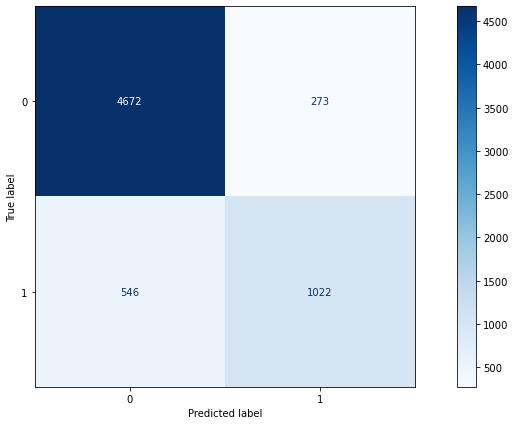

In [11]:
aux.plot_cm(model_boosting_p1, X_validation, y_validation)

Mostramos el gráfico de la curva roc:

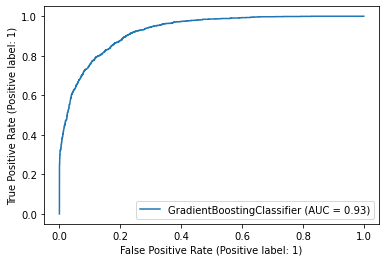

In [12]:
plot_roc_curve(model_boosting_p1, X_validation, y_validation, response_method="predict_proba")
plt.show()

<h3> Preprocesamiento 2: Reducción por Frecuencia + OHE</h3>

A diferencia del preprocesado anterior, ahora reduciremos por frecuencia de aparición algunas columnas dejando solo las categorias que tengan más del 15% de los datos y agrupando en una misma las demás. Luego aplicaremos OHE a las columnas categóricas. Al realizar este primer preproceso obtenemos una reduccion dimensional cuando apliquemos OHE. Las columnas que reduciremos son: 'Barrio', 'Religión', 'Categoría de Trabajo' y 'Estado Marital', que son features con categorias con muy pocos datos según lo analizado en el TP1

In [13]:
X_p2 = reduce_by_frequency(X, ['barrio', 'religion', 'categoria_de_trabajo', 'estado_marital'], 0.15)

In [14]:
init_OHE(X_p2)
X_p2 = apply_OHE(X_p2)

In [15]:
X_train, X_validation, y_train, y_validation = train_test_split(
    X_p2, y, random_state=0, test_size=0.2, stratify=y
)

Buscamos los mejores hiperparametros para Boosting con GridSearchCV:

    - La métrica que se utiliza para comparar los modelos obtenidos en cada iteracion es roc_auc_score.
    - El intervalo de min_samples_leaf tiene un paso de 50 valores ya que consideramos que una diferencia menor a este valor resulta ser irrelevante para las metricas que se calculan.
    - El intervalo de max_depth tiene un paso de 5 valores ya que consideramos que una diferencia menor a este valor resulta ser irrelevante para las metricas que se calculan.
    - la funcion de perdida quedó definida como 'deviance' ya que se obtuvo el mismo resultado en multiples corridas con hiperparametros diferentes
    - El número de estimadores óptimo para las metricas que se calculan siempre estuvo en el intervalo [200, 400], por lo se limitan las opciones a esos valores.
    - El learning rate se mantiene en esos valores ya que se probo incrementandolo y se obtuvo el mismo resultado

In [16]:
parameters = {'max_depth': np.arange(5, 11, 1), 'min_samples_leaf': np.arange(50, 101, 50),'n_estimators': np.arange(200, 401, 100), 'learning_rate': np.array([0.1, 0.01])}

clf = GradientBoostingClassifier(random_state = 0)

gscv = GridSearchCV(
    clf,  parameters, scoring='roc_auc', n_jobs=-1, cv=5, return_train_score=True,
).fit(X_train, y_train)

In [17]:
print(f"Mejor score ROC-AUC en Entrenamiento: {gscv.best_score_}")
print(f"Mejores Parametros {gscv.best_params_}")

print(f"\nMejor score ROC-AUC en Validación: {gscv.score(X_validation, y_validation)}")

Mejor score ROC-AUC en Entrenamiento: 0.9262119863286247
Mejores Parametros {'learning_rate': 0.1, 'max_depth': 6, 'min_samples_leaf': 50, 'n_estimators': 200}

Mejor score ROC-AUC en Validación: 0.9249455103072575


In [18]:
model_boosting_p2 = gscv.best_estimator_
model_boosting_p2

GradientBoostingClassifier(max_depth=6, min_samples_leaf=50, n_estimators=200,
                           random_state=0)

Predecimos con el set de validación:

In [19]:
y_pred_p2 = model_boosting_p2.predict(X_validation)

### Métricas

In [20]:
print(classification_report(y_validation, y_pred_p2))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      4945
           1       0.78      0.64      0.70      1568

    accuracy                           0.87      6513
   macro avg       0.84      0.79      0.81      6513
weighted avg       0.86      0.87      0.87      6513



Mostramos la matriz de confusión:

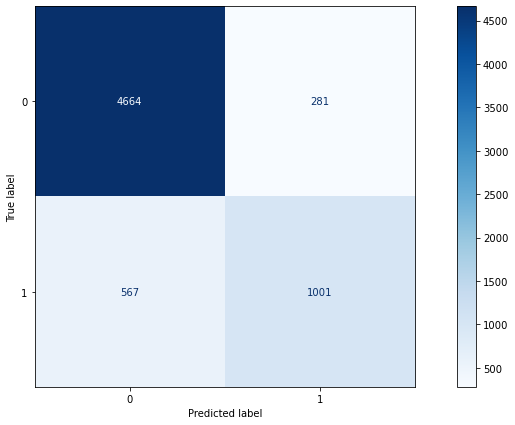

In [21]:
aux.plot_cm(model_boosting_p2, X_validation, y_validation)

Mostramos el gráfico de la curva roc:

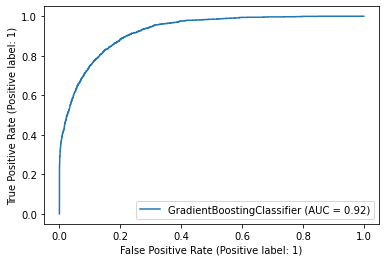

In [22]:
plot_roc_curve(model_boosting_p2, X_validation, y_validation, response_method="predict_proba")
plt.show()

<h3> Preprocesamiento 3: Eliminación de Columnas + Reducción por Frecuencia + OHE </h3>

En este preprocesamiento eliminamos las columnas 'religion', 'barrio' y 'categoria de trabajo' ya que en el análisis del TP1 concluimos que no aportaban demasiada información. Además agrupamos las categorias que contienen menos del 5% de los datos, y finalmente aplicamos One Hot Encoding

In [23]:
X_p3 = eliminar_features(X, ['religion', 'barrio', 'categoria_de_trabajo'])
X_p3 = reduce_by_frequency(X_p3, ['estado_marital', 'trabajo'], 0.05)

In [24]:
init_OHE(X_p3)
X_p3 = apply_OHE(X_p3)

In [25]:
X_train, X_validation, y_train, y_validation = train_test_split(
    X_p3, y, random_state=0, test_size=0.2, stratify=y
)

Buscamos los mejores hiperparametros para Boosting con GridSearchCV:

    - La métrica que se utiliza para comparar los modelos obtenidos en cada iteracion es roc_auc_score.
    - El intervalo de min_samples_leaf tiene un paso de 50 valores ya que consideramos que una diferencia menor a este valor resulta ser irrelevante para las metricas que se calculan.
    - El intervalo de max_depth tiene un paso de 5 valores ya que consideramos que una diferencia menor a este valor resulta ser irrelevante para las metricas que se calculan.
    - la funcion de perdida quedó definida como 'deviance' ya que se obtuvo el mismo resultado en multiples corridas con hiperparametros diferentes
    - El número de estimadores óptimo para las metricas que se calculan siempre estuvo en el intervalo [200, 400], por lo se limitan las opciones a esos valores.
    - El learning rate se mantiene en esos valores ya que se probo incrementandolo y se obtuvo el mismo resultado

In [26]:
parameters = {'max_depth': np.arange(5, 11, 1), 'min_samples_leaf': np.arange(50, 101, 50),'n_estimators': np.arange(200, 401, 100), 'learning_rate': np.array([0.1, 0.01])}

clf = GradientBoostingClassifier(random_state = 0)

gscv = GridSearchCV(
    clf,  parameters, scoring='roc_auc', n_jobs=-1, cv=5, return_train_score=True,
).fit(X_train, y_train)

In [27]:
print(f"Mejor score ROC-AUC en Entrenamiento: {gscv.best_score_}")
print(f"Mejores Parametros {gscv.best_params_}")

print(f"\nMejor score ROC-AUC en Validación: {gscv.score(X_validation, y_validation)}")

Mejor score ROC-AUC en Entrenamiento: 0.9239250764149028
Mejores Parametros {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 50, 'n_estimators': 200}

Mejor score ROC-AUC en Validación: 0.9220163507769135


In [28]:
model_boosting_p3 = gscv.best_estimator_
model_boosting_p3

GradientBoostingClassifier(max_depth=5, min_samples_leaf=50, n_estimators=200,
                           random_state=0)

Predecimos con el set de validación:

In [29]:
y_pred_p3 = model_boosting_p3.predict(X_validation)

### Métricas

In [30]:
print(classification_report(y_validation, y_pred_p3))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      4945
           1       0.78      0.61      0.68      1568

    accuracy                           0.87      6513
   macro avg       0.83      0.78      0.80      6513
weighted avg       0.86      0.87      0.86      6513



Mostramos la matriz de confusión:

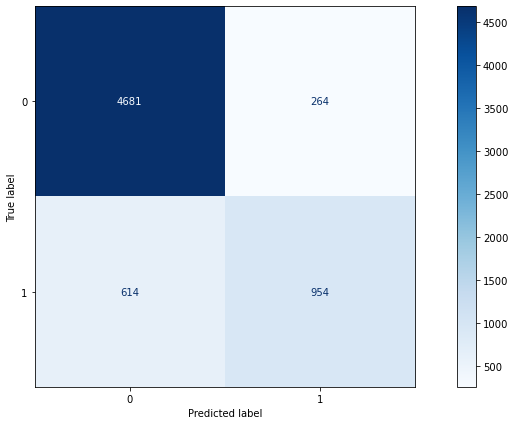

In [31]:
aux.plot_cm(model_boosting_p3, X_validation, y_validation)

Mostramos el gráfico de la curva roc:

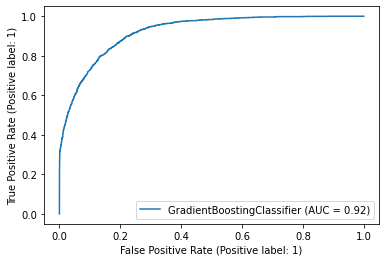

In [32]:
plot_roc_curve(model_boosting_p3, X_validation, y_validation, response_method="predict_proba")
plt.show()

<h1>Conclusión</h1>

Vemos que hay muy poca diferencia entre ambos preprocesados, siendo el primer preprocesado sutilmente mejor. Entonces nos quedaremos con el primer modelo.

<h1>Predicción</h1>

In [33]:
ids, X_holdout = aux.get_holdout_set()

In [34]:
X_holdout = init_dataset(X_holdout)

In [35]:
init_OHE(X)
X_holdout_p1 = apply_OHE(X_holdout)

In [36]:
model_boosting_pred = model_boosting_p1.predict(X_holdout_p1)

In [37]:
aux.create_prediction(ids, model_boosting_pred, file_name='boosting')